**C-CNN Model : Contrastive CNN for OSR task**


Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import copy
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.manifold import TSNE
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Please Note: normalization values for the input data are set to 0.5 for both mean and standard deviation. While these values may not correspond to the exact mean and std of the entire dataset, empirical results have shown that using these normalization values consistently yields the best performance across various datasets.

This augmentation is designed to be used with the MNIST dataset for contrastive learning with the InfoNCE.

Augmentation steps:
1. ToTensor: Convert the images to PyTorch tensors.
2. Normalize: Normalize the pixel values to have a range of [-1, 1].
3. GaussianBlur: Apply Gaussian blur to the images with random kernel size and sigma.
4. RandomAffine: Apply random affine transformations, including rotation, translation, and scaling.

The augmented dataset can then be used in conjunction with a contrastive learning algorithm
using the InfoNCE loss to learn meaningful representations from the MNIST dataset.

In [2]:


aug_transform = T.Compose([T.ToTensor(),
                      # T.Normalize((0.13066037,), (0.30810845,)),
                      T.Normalize((0.5,), (0.5,)),
                      T.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 1)),
                      T.RandomAffine(degrees=(-20, 20), translate=(0.01, 0.15),
                                     scale=(0.9, 1.1),fill=-1)
                              ])
val_transform = T.Compose([T.ToTensor() ,
                           T.Normalize((0.5,), (0.5,))
                          #  T.Normalize((0.13066037,), (0.30810845,))
                           ])

svhn_transform = T.Compose([

    T.Grayscale(),
    T.Resize((28, 28)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
    # T.Normalize((0.45463002,), (0.21985805,))
])

cifar_transform = T.Compose([
    T.Grayscale(),
    T.Resize((28, 28)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
    # T.Normalize((0.4841099,), (0.23128399,))
])

This get_loaders function is responsible for obtaining data loaders for different datasets, including MNIST, SVHN, and CIFAR-10. It utilizes augmentation and validation transformations previously defined to preprocess the data before loading it into the network for training, validation, and testing purposes.

In [3]:
def get_loaders():
  # DATA - note we use 2 train sets, baseline and aug
  mnist_trainset_aug = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=val_transform)
  mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=val_transform)
  mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=val_transform)

  svhn_train_dataset = torchvision.datasets.SVHN('svhn_data', split='train', download=True, transform=svhn_transform)

  svhn_test_dataset = torchvision.datasets.SVHN('svhn_data', split='test', download=True, transform=svhn_transform)

  cifar_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=svhn_transform, download=True)

  train_size = int(0.8 * len(mnist_trainset))
  val_size = len(mnist_trainset) - train_size
  train_dataset, val_dataset = torch.utils.data.random_split(mnist_trainset, [train_size, val_size])

  mnist_trainloader_aug = torch.utils.data.DataLoader(mnist_trainset_aug, batch_size=batch_size,
                                                      num_workers=2)

  mnist_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                num_workers=2)
  mnist_valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

  mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

  svhn_test_dataset.labels = torch.Tensor([10 for label in svhn_test_dataset.labels])
  svhn_test_loader = torch.utils.data.DataLoader(svhn_test_dataset, batch_size=batch_size, shuffle=True)
  cifar_test_dataset.targets = torch.Tensor([10 for label in cifar_test_dataset.targets])
  cifar_test_loader = torch.utils.data.DataLoader(cifar_test_dataset, batch_size=batch_size, shuffle=False)
  return mnist_trainloader, mnist_valloader, mnist_testloader, svhn_test_loader, cifar_test_loader

The plot_train_and_val_loss method generates a line plot to visualize the training and validation loss over epochs during the training process. It takes two input lists, train_loss_total and val_loss_total, which represent the recorded training and validation losses, respectively. The plotted graph allows users to easily compare the trends of the training and validation losses and assess the model's generalization performance.

In [4]:
def plot_train_and_val_loss(train_loss_total, val_loss_total):
  plt.figure(figsize=(15,10))
  plt.plot(train_loss_total, label="Train Loss")
  plt.plot(val_loss_total, label="Validation Loss")
  plt.legend()
  plt.grid()
  plt.title("Train vs Validation loss")

CombinedDataset (Given in the project utils)

In [5]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10

The CNN model for OSR task. It consists of two convolutional layers followed by max-pooling operations to extract features from the input images. The output is then flattened and passed through fully connected layers to predict one of the ten classes. The model also implements a mechanism to detect OOD based on learned thresholds and latent vectors. Before setting the thresholds, it performs standard training, computing output probabilities through the fully connected layers and applying the softmax activation. After defining the thresholds, it enables OSR task during inference by checking the distances between latent vectors and predefined means and assigning the extra class (-1) to images with latent vectors that do not fall within the defined thresholds.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.fc1 = nn.Linear(32 * 7 * 7, 15)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(15, 10)
        self.thresholds = None
        self.means = []

        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        z = self.relu(self.fc1(x))
        if self.thresholds:

          output = []
          for i in range(z.shape[0]):
              latent_vec = z[i].to(device)

              distances =[torch.dist(mean, latent_vec) for mean in self.means]
              if any(distances[i] < thresholds[i] for i in range(len(thresholds))):
                img_output = self.fc2(z[i])

                img_output = self.softmax(img_output)
                img_output = torch.cat((img_output, torch.tensor([-100]).to(device)), dim=-1)
              else:
                img_output_shape = (11,)  # Shape of the tensor
                img_output = -torch.ones(img_output_shape).to(device)  # Fill the tensor with -1
                img_output[-1] = 0  # Set the last coordinate to 0

              output.append(img_output.detach().cpu().numpy())
          output = torch.tensor(np.stack(output)).to(device)
        else:
          output = self.fc2(z)
          output = self.softmax(output)
          output = torch.cat((output, torch.full((output.shape[0], 1), -100).to(device)), dim=-1)
        return output, z    # return x for visualization

Implementation of InfoNCE loss. please refer to our readme for more information

In [7]:
class contrastive_loss(nn.Module):
    def __init__(self, tau=1, normalize=False):
        super(contrastive_loss, self).__init__()
        self.tau = tau
        self.normalize = normalize

    def forward(self, xi, xp, xn):
        # xi: [b x dim]
        # xp: [b x dim] - means there is only one positive per sample, could be extended easily
        # xn: [b x cneg x dim] - cneg number of negatives per sample

        # transpose xn for computations
        xn = xn.transpose(0, 1)

        # top
        if self.normalize:  # False
            sim_mat_denom = torch.norm(xi, dim=1) * torch.norm(xp, dim=1)
            numerator = torch.exp(torch.sum(xi * xp, dim=-1) / sim_mat_denom / self.tau)
        else:
            numerator = torch.exp(torch.sum(xi * xp, dim=-1) / self.tau)

        # bottom
        if self.normalize:
            # (f_mean * y.transpose(0, 1)).sum(dim=0).sum(dim=-1)
            sim_mat_denom = torch.norm(xi, dim=1) * torch.norm(xn, dim=-1)
            denominator = torch.exp(torch.sum(xi * xn, dim=-1) / sim_mat_denom / self.tau)
        else:
            denominator = torch.exp(torch.sum(xi * xn, dim=-1) / self.tau)

        denominator = denominator.sum(dim=0)
        # new loss
        loss = torch.mean(-torch.log(numerator / (numerator + denominator)))

        return loss, torch.mean(numerator), torch.mean((numerator + denominator))

    Parameters:
        model: The model to use for inference and feature extraction.
        percentage: The percentage of sorted distances to use as OOD threshold.

    Returns:
        tuple: A tuple containing two elements:
            - thresholds: A list of computed OOD thresholds for each class.
            - label_means: A list of class-specific centers (mean latent vectors).

    This method calculates OOD thresholds and class-specific centers (means) using a OSR model and
    the MNIST training set. It first extracts latent vectors corresponding to each class from the training data.
    Then, it calculates the mean latent vector for each class and computes the distances between individual latent
    vectors and their respective class mean. The distances are sorted for each class, and the threshold is determined
    by selecting a value at the provided percentage. The method returns the computed thresholds and class-specific
    centers as a tuple, which can be used during inference to identify potential novel instances in the data.

    Note: We use here euclidian distances based on emprical results tested on
    Euclidian Distance, Cosine distance, Manhattan distance and Jaccard distance

In [8]:
def compute_thresholds_and_centers(model, percentage):
  labels_latent_vectors = [[] for label in range(10)]
  for i,  (images, labels) in enumerate(mnist_trainloader):
      images = images.to(device)
      labels = labels.to(device)
      outputs, z = model(images)
      for vector, label in zip(z, labels):
          labels_latent_vectors[label.item()].append(vector)

  label_means = [torch.mean(torch.stack(label_latent_vectors), dim=0) for label_latent_vectors in labels_latent_vectors]
  labels_distances = [[torch.dist(label_mean, label_latent_vector) for label_latent_vector in label_latent_vectors] for label_latent_vectors, label_mean in zip(labels_latent_vectors, label_means)]
  labels_sorted_distances = [sorted(label_distances, key=lambda x: x.item()) for label_distances in labels_distances]
  thresholds = [label_sorted_distances[int(percentage * len(label_sorted_distances))] for label_sorted_distances in labels_sorted_distances]
  return thresholds, label_means


In [9]:
def L2_distance(tensor1, tensor2):
    return torch.dist(tensor1, tensor2)

def L1_distance(tensor1, tensor2):
    return torch.sum(torch.abs(tensor1 - tensor2))

def cosine_distance(tensor1, tensor2):
    return 1 - F.cosine_similarity(tensor1, tensor2)

def jaccard_distance(tensor1, tensor2):
    intersection = torch.logical_and(tensor1, tensor2).sum()
    union = torch.logical_or(tensor1, tensor2).sum()
    return 1 - (intersection / union)

In [10]:
def compute_thresholds_and_centers_exp(model, percentage, metric):
  labels_latent_vectors = [[] for label in range(10)]
  for i,  (images, labels) in enumerate(mnist_trainloader):
      images = images.to(device)
      labels = labels.to(device)
      outputs, z = model(images)
      for vector, label in zip(z, labels):
          labels_latent_vectors[label.item()].append(vector)

  label_means = [torch.mean(torch.stack(label_latent_vectors), dim=0) for label_latent_vectors in labels_latent_vectors]
  labels_distances = [[metric(label_mean, label_latent_vector) for label_latent_vector in label_latent_vectors] for label_latent_vectors, label_mean in zip(labels_latent_vectors, label_means)]
  labels_sorted_distances = [sorted(label_distances, key=lambda x: x.item()) for label_distances in labels_distances]
  thresholds = [label_sorted_distances[int(percentage * len(label_sorted_distances))] for label_sorted_distances in labels_sorted_distances]
  return thresholds, label_means

We use TSNE to plot the latent space of the CombinedDataset

In [11]:
def tnse_plot_zi(colors, tsne, train_loader, model):
    # # Compute the embeddings for the entire train set
    model.eval()
    with torch.no_grad():
        embeddings = []
        labels = []
        for i, (images, batch_labels) in enumerate(train_loader):
            images, batch_labels = images.to(device), batch_labels.to(device)
            if i > 5:
                break
            x = model.conv1(images)
            x = model.conv2(x)
            x = x.view(x.size(0), -1)
            zi = model.relu(model.fc1(x))
            embeddings.append(zi.cpu().numpy())
            labels.append(batch_labels.cpu().numpy())
        embeddings = np.concatenate(embeddings, axis=0)
        labels = np.concatenate(labels, axis=0)
    # Compute the tSNE embeddings
    latent_vars_tsne = tsne.fit_transform(embeddings)
    # Plot the embeddings
    fig, ax = plt.subplots()
    for j in range(11):
        idx = np.where(labels == j)[0]
        ax.scatter(latent_vars_tsne[idx, 0], latent_vars_tsne[idx, 1], color=colors[j], label=str(j))
    ax.legend()
    plt.pause(0.1)

In this method, we use contrastive learning while using infoNCE loss to move samples from different labels apart and bring samples from the same label together within the latent space.
Starting points: model's latent vectors
Positive examples: MNIST augmentation
Negative examples: batch shuffle based on the fact that there are 10 live and with a 9/10 chance each example will meet a corresponding negative example. Also, we grill more than one negative sample for the starting points

In [12]:
def calculate_contrastive_loss(inputs, contras_fn):
    batch_size = inputs.shape[0]
    transform = T.Compose([
        T.ToPILImage(),  # Convert to PIL Image
        T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1)),
        T.RandomAffine(degrees=(-20, 20), translate=(0.01, 0.15), scale=(0.9, 1.1), fill=-1),
        T.ToTensor()  # Convert back to tensor
    ])

    augmented_inputs = torch.stack([transform(image) for image in inputs])

    # Move inputs and labels to device/cuda
    augmented_inputs = augmented_inputs.to(device)
    reshaped_inputs = inputs.view(batch_size, -1)
    reshaped_augmented_inputs = augmented_inputs.view(batch_size, -1)
    # Initialize an empty tensor with the desired shape
    neg_examples = torch.empty(batch_size, 10, 784).to(device)

    # Loop over the first dimension
    for i in range(batch_size):
    # Randomly choose 10 indices from the range [0, 128)
      indices = torch.randint(0, batch_size, (10,))

    # Use these indices to select vectors from x
      selected_vectors = reshaped_inputs[indices]

    # Store these vectors in the new tensor
      neg_examples[i] = selected_vectors
    contrastive_loss, _, _ = contras_fn(reshaped_inputs, reshaped_augmented_inputs, neg_examples)
    return contrastive_loss

Test OSR Dataset - based on the method given in the project utils

In [13]:
def test_osr_dataset(model, data_loader):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()
    y_true_labels = []
    y_pred_labels = []

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs, _ = model(data)

            ### Modify output if needed ###

            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.

            # Assuming the model returns an (N_batch, 11) size output
            _, y_pred = torch.max(outputs, 1)

	    # Assuming the model retuns the predicted label (N_batch, )
	    # y_pred = outputs

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

            y_true_labels.extend(labels.cpu().numpy())
            y_pred_labels.extend(y_pred.cpu().numpy())

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total, y_true_labels, y_pred_labels

The `compute_model_acc_on_test` function calculates the accuracy of the provided classification `model`. It evaluates the model's performance just on the classification task, before computing the OSR thresholds.


In [14]:
# computes accuracy on test set for numerical labels
def compute_model_acc_on_test(model, dataloader):
  correct_count, all_count = 0, 0
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # logits
        outputs, _ = model(inputs)
        # preds_proba = softmax(outputs)
        _, preds = torch.max(outputs, 1)
        # eval labels here numeric (not one-hot)
        correct_pred = torch.eq(labels, preds).cpu()
        correct_count += correct_pred.numpy().sum()
        all_count += len(labels)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

  print("Number Of Images Tested =", all_count)
  print("Model Accuracy =", (correct_count/all_count))
  print("---")
  return y_true, y_pred

Train epoch:
We use here both CrossEntropy Loss and InfoNCE Loss. And we created the pipeline add L1/L2 regularization

In [15]:
def train_epoch(model, dataloader, criterion, optimizer, regularization=None):
  model.train()
  epoch_loss = 0

  for i, data in enumerate(dataloader, 0):

      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      # mode to device/cuda
      inputs, labels = inputs.to(device), labels.to(device)


      # zero the parameter gradients
      optimizer.zero_grad()
      logits, _= model(inputs)

      # Cross-entropy loss - input=logits
      loss = criterion(logits, labels)
      loss += calculate_contrastive_loss(inputs, contras_fn)
      # Compute the L1/L2 norm on the model's weight and add to the loss
      if regularization == "L1":
        l1_lambda = 0.0001
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        loss = loss + l1_lambda * l1_norm
      elif regularization == "L2":
        l2_lambda = 0.0001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

      loss.backward()
      optimizer.step()
      # for visualizaiton
      epoch_loss += loss.cpu().detach().item() / len(dataloader)

  return epoch_loss

Calculate the loss on the validation set

In [16]:
def calculate_val_epoch_loss(model, dataloader, criterion):
  epoch_loss = 0
  model.eval()   # Set model to evaluate mode
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):

      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      # mode to device/cuda
      inputs, labels = inputs.to(device), labels.to(device)
      logits, _ = model(inputs)

      #pred_probab = softmax(logits)
      # Cross-entropy loss

      loss = criterion(logits, labels)
      loss += calculate_contrastive_loss(inputs, contras_fn)
      epoch_loss += loss.cpu().detach().item() / len(dataloader)
  return epoch_loss

MAIN -

100%|██████████| 9912422/9912422 [00:00<00:00, 58087566.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68207034.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25979277.09it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11651699.55it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 182040794/182040794 [00:07<00:00, 25137430.87it/s]


100%|██████████| 64275384/64275384 [00:05<00:00, 12424395.06it/s]


100%|██████████| 170498071/170498071 [00:02<00:00, 75015870.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 10/10 [16:36<00:00, 99.63s/it]


Number Of Images Tested = 10000
Model Accuracy = 0.9777
---
Confusion Matrix for MNIST:
[[ 971    1    0    1    0    1    4    0    2    0]
 [   0 1128    1    0    0    2    1    0    3    0]
 [   3    5 1004    4    4    0    0    9    3    0]
 [   0    1    2  979    0   18    0    4    4    2]
 [   0    1    0    0  977    0    0    2    0    2]
 [   0    1    0    6    0  882    3    0    0    0]
 [   6    5    3    0    8    8  927    0    1    0]
 [   0    6    4    3    4    0    0 1008    1    2]
 [   2    2    0    4    1   12    1    2  948    2]
 [   2    1    0    4   13   22    1    8    5  953]]

Binary Accuracy for OOD: 95.55

Confusion Matrix for OOD:
[[9855  145]
 [ 745 9255]]

Confusion Matrix for OSR:
[[ 958    0    0    1    0    0    2    0    2    0   17]
 [   0 1124    1    0    0    1    1    0    3    0    5]
 [   3    5  985    4    4    0    0    8    3    0   20]
 [   0    1    1  964    0   17    0    4    4    2   17]
 [   0    1    0    0  963    0    0

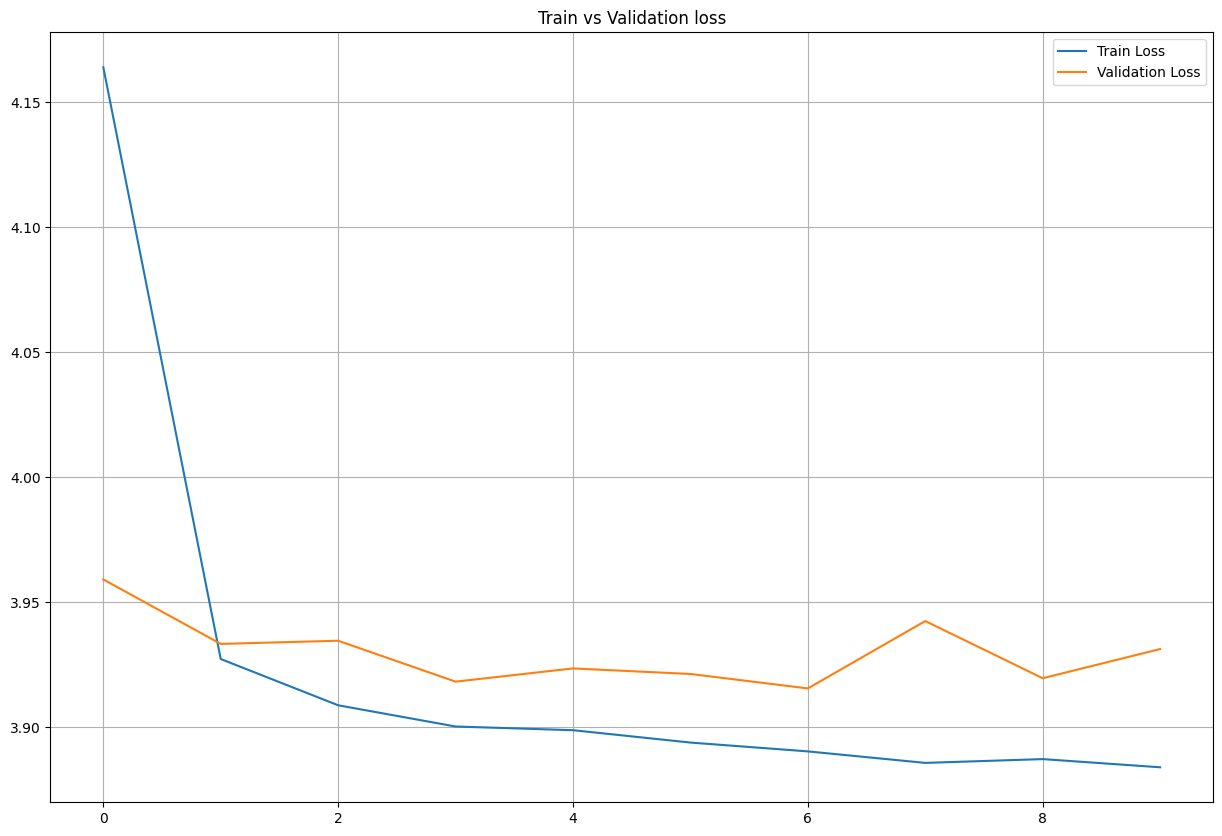

In [17]:
# Main

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Configuration and hyperparameters
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_trainloader, mnist_valloader, mnist_testloader, svhn_test_loader, cifar_test_loader = get_loaders()
model = CNN().to(device)
softmax = nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()
n_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Lists to store training and validation loss
train_loss_total = []
val_loss_total = []

# Contrastive loss function for training
contras_fn = contrastive_loss(tau=0.5, normalize=True)

# Create combined dataset for evaluation
mnist = MNIST(root='./data', train=False, download=True, transform=val_transform)
ood = CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)
combined_ds = CombinedDataset(mnist, ood)
eval_osr_batch_size = 1024
data_loader = DataLoader(combined_ds, batch_size=eval_osr_batch_size, shuffle=True)

# Training loop
for epoch in tqdm(range(n_epochs)):
  train_loss = train_epoch(model, mnist_trainloader, criterion, optimizer)
  val_loss = calculate_val_epoch_loss(model, mnist_valloader, criterion)
  train_loss_total.append(train_loss)
  val_loss_total.append(val_loss)

# Plot training and validation loss
plot_train_and_val_loss(train_loss_total, val_loss_total)

# Compute classification accuracy on the MNIST test set
true_labels, predicted_labels = compute_model_acc_on_test(model, mnist_testloader)

conf_matrix_mnist = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix for MNIST:")
print(conf_matrix_mnist)

#Visualization using t-SNE on the combined dataset
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black']
tsne = TSNE(n_components=2, random_state=42)
tnse_plot_zi(colors, tsne, data_loader, model)

# Compute thresholds and centers and configure the model for eval
thresholds, label_means = compute_thresholds_and_centers(model, 0.98)
model.thresholds = thresholds
model.means = label_means

# Evaluate OSR on the combined dataset
acc_mnist, acc_ood, acc_total, y_true, y_pred = test_osr_dataset(model, data_loader)
y_true_ood = [0 if label < 10 else 1 for label in y_true]
y_pred_ood = [0 if label < 10 else 1 for label in y_pred]

conf_matrix_mnist = confusion_matrix(y_true_ood, y_pred_ood)
binary_acc = (conf_matrix_mnist[0][0] + conf_matrix_mnist[1][1]) * 100 / (conf_matrix_mnist[0][0] + conf_matrix_mnist[0][1] + conf_matrix_mnist[1][0] + conf_matrix_mnist[1][1])
print("\nBinary Accuracy for OOD: " + str(binary_acc))
print("\nConfusion Matrix for OOD:")
print(conf_matrix_mnist)

conf_matrix_mnist = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix for OSR:")
print(conf_matrix_mnist)

print(f'\nMNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')


In [22]:
print("\nBinary Accuracy for OOD: " + str(binary_acc))
print("\nConfusion Matrix for OOD:")
print(conf_matrix_mnist)

conf_matrix_mnist = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix for OSR:")
print(conf_matrix_mnist)

print(f'\nMNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')


Binary Accuracy for OOD: 95.55

Confusion Matrix for OOD:
[[ 958    0    0    1    0    0    2    0    2    0   17]
 [   0 1124    1    0    0    1    1    0    3    0    5]
 [   3    5  985    4    4    0    0    8    3    0   20]
 [   0    1    1  964    0   17    0    4    4    2   17]
 [   0    1    0    0  963    0    0    2    0    2   14]
 [   0    1    0    4    0  869    3    0    0    0   15]
 [   6    4    3    0    7    6  909    0    1    0   22]
 [   0    5    4    3    3    0    0  995    1    2   15]
 [   2    2    0    3    1   12    1    2  941    2    8]
 [   2    1    0    4   12   21    1    8    5  943   12]
 [  52   31   79  255   84   76   10   37   19  102 9255]]

Confusion Matrix for OSR:
[[ 958    0    0    1    0    0    2    0    2    0   17]
 [   0 1124    1    0    0    1    1    0    3    0    5]
 [   3    5  985    4    4    0    0    8    3    0   20]
 [   0    1    1  964    0   17    0    4    4    2   17]
 [   0    1    0    0  963    0    0    2  

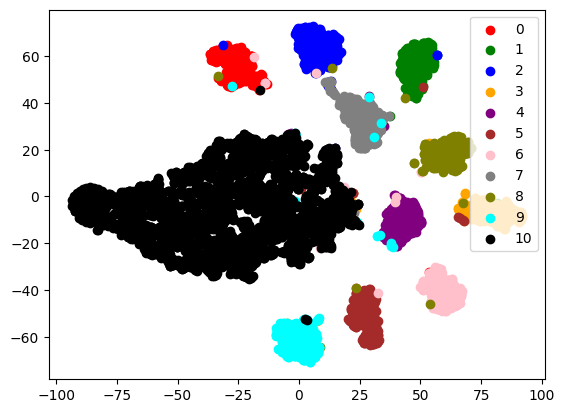

In [23]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black']
tsne = TSNE(n_components=2, random_state=42)
tnse_plot_zi(colors, tsne, data_loader, model)

Results from experiments we performed. All the full details of the experiments can be found in detail in the read me

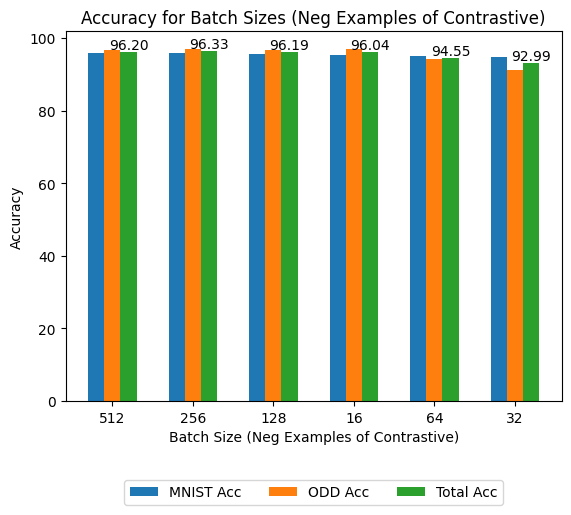

In [18]:
import matplotlib.pyplot as plt

mnist_Acc = [95.84, 95.74, 95.61, 95.21, 95.02, 94.87]
ODD_Acc = [ 96.57, 96.92, 96.76, 96.88, 94.08, 91.11]
Total_acc = [96.2, 96.33, 96.185,96.04,94.55, 92.99 ]

batch_size = [512, 256, 128, 16,64, 32]

bar_width = 0.2
x_indices = np.arange(len(batch_size))

bar1 = plt.bar(x_indices  - bar_width, mnist_Acc, bar_width, label='MNIST Acc')
bar2 = plt.bar(x_indices , ODD_Acc, bar_width, label='ODD Acc')
bar3 = plt.bar(x_indices  + bar_width, Total_acc, bar_width, label='Total Acc')

plt.xticks(x_indices , batch_size)

plt.xlabel('Batch Size (Neg Examples of Contrastive)')
plt.ylabel('Accuracy')
plt.title('Accuracy for Batch Sizes (Neg Examples of Contrastive)')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)


def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')


autolabel(bar3)


plt.show()


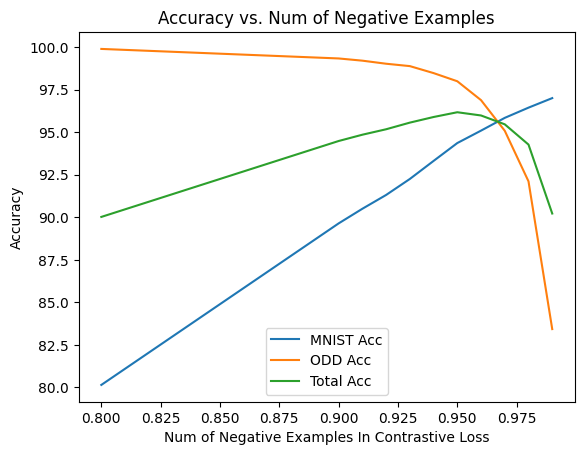

In [19]:
import matplotlib.pyplot as plt

mnist_Acc = [80.15, 89.64, 90.50, 91.31, 92.25, 93.31, 94.36, 95.09, 95.84, 96.44, 97.00]
ODD_Acc = [99.89, 99.33, 99.20, 99.02, 98.88, 98.47, 97.99, 96.88, 95.08, 92.11, 83.43]
Total_acc = [90.02, 94.48, 94.85, 95.17, 95.56, 95.89, 96.17, 95.98, 95.46, 94.27, 90.22]

threshold_percentage = [0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

plt.plot(threshold_percentage, mnist_Acc, label='MNIST Acc')
plt.plot(threshold_percentage, ODD_Acc, label='ODD Acc')
plt.plot(threshold_percentage, Total_acc, label='Total Acc')

plt.xlabel('Num of Negative Examples In Contrastive Loss')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Num of Negative Examples')

plt.legend()

plt.show()


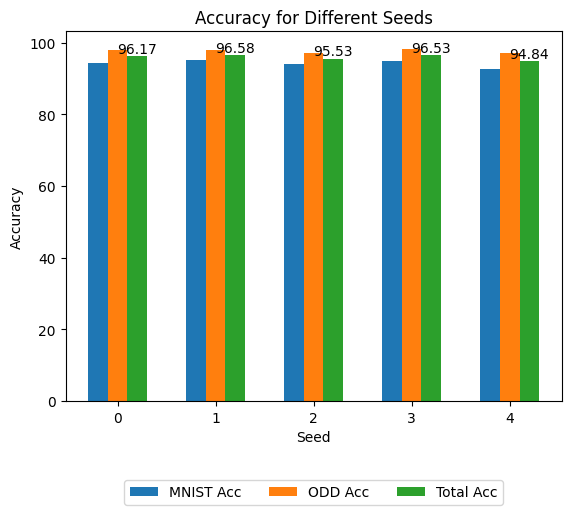

In [20]:
import matplotlib.pyplot as plt

mnist_Acc = [ 94.36, 95.15, 93.9, 94.87, 92.56]
ODD_Acc = [ 97.99, 98.02, 97.17, 98.20, 97.04]
Total_acc = [ 96.17, 96.58, 95.535, 96.53, 94.84]

seed = [0, 1, 2, 3, 4]

bar_width = 0.2
x_indices = np.arange(len(seed))

plt.bar(x_indices  - bar_width, mnist_Acc, bar_width, label='MNIST Acc')
plt.bar(x_indices , ODD_Acc, bar_width, label='ODD Acc')
bar3 = plt.bar(x_indices  + bar_width, Total_acc, bar_width, label='Total Acc')

plt.xticks(x_indices , seed)

plt.xlabel('Seed')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Seeds')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)


def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')


autolabel(bar3)

plt.show()

In [21]:
  PATH = './model_path.pth'
  torch.save(model.state_dict(), PATH)